In [ ]:
import marimo as mo

# Baby Cry Classification - Exploratory Data Analysis

This notebook performs EDA on the Baby Cry dataset. The process is divided into:
1. **Data Collection**: Loading the dataset from Hugging Face.
2. **Data Preparation**: Checking audio properties and structure.
3. **Exploratory Data Analysis**: Visualizing class distribution, audio duration, and signal characteristics (waveforms/spectrograms).

In [1]:
import datasets
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dotenv
import os
from huggingface_hub import login
import random

# Configure plotting
sns.set_theme(style="whitegrid")

/Users/Dasha/Code/gym/zoomcamps/ml-zoomcamp-projects/baby-cry-classifier/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dotenv.load_dotenv(dotenv.find_dotenv(usecwd=True))
HUGGING_FACE_PAT = os.environ.get("HUGGING_FACE_PAT")

In [3]:
if HUGGING_FACE_PAT:
    login(token=HUGGING_FACE_PAT)
    print("Logged in to Hugging Face")
else:
    print("HUGGING_FACE_PAT not found in .env")

Logged in to Hugging Face


## 1. Data Collection

We load the `mahmudulhasan01/baby_crying_sound` dataset from Hugging Face.

In [4]:
DATASET_PATH = "mahmudulhasan01/baby_crying_sound"
ds = datasets.load_dataset(DATASET_PATH, split="train")

In [5]:
print(f"Dataset loaded with {len(ds)} samples.")
print(f"Features: {ds.features}")
ds

Dataset loaded with 1313 samples.
Features: {'audio': Audio(sampling_rate=None, decode=True, num_channels=None, stream_index=None), 'label': ClassLabel(names=['belly pain', 'burping', 'cold_hot', 'discomfort', 'hungry', 'laugh', 'noise', 'silence', 'tired'])}


Dataset({
    features: ['audio', 'label'],
    num_rows: 1313
})

## 2. Data Preparation

In this section, we inspect the raw data to understand its structure.
We look at the sampling rate and verify the label mapping.

In [6]:
# Inspect the first sample to understand structure
sample = ds[0]
audio_info = sample["audio"]
print(f"Sample 0 Audio Info: {audio_info}")

labels = ds.features["label"].names
print(f"Labels: {labels}")

Sample 0 Audio Info: <datasets.features._torchcodec.AudioDecoder object at 0x12bf6c2f0>
Labels: ['belly pain', 'burping', 'cold_hot', 'discomfort', 'hungry', 'laugh', 'noise', 'silence', 'tired']


In [7]:
import IPython.display as ipd

def play_random_sample(ds):
    sample_id = random.randint(0, len(ds) - 1)
    sample = ds[sample_id]

    audio = sample["audio"]
    waveform = audio["array"]
    sampling_rate = audio["sampling_rate"]

    label_id = sample["label"]
    label_text = ds.features["label"].int2str(label_id)

    print(f"Reading sound for sample_id: {sample_id} - label: {label_text} - sampling rate: {audio["sampling_rate"]}")
    ipd.display(ipd.Audio(waveform, rate=sampling_rate))

play_random_sample(ds)

Reading sound for sample_id: 260 - label: cold_hot - sampling rate: 8000


## 3. Exploratory Data Analysis

We will analyze:
- **Class Distribution**: Is the dataset balanced?
- **Audio Duration**: How long are the recordings?
- **Signal Visualization**: Waveforms and Spectrograms.

### Class Distribution

/var/folders/75/16tkjd9j02s_vqb9wh7gfnjw0000gp/T/ipykernel_77589/2332618269.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_names, palette="viridis")


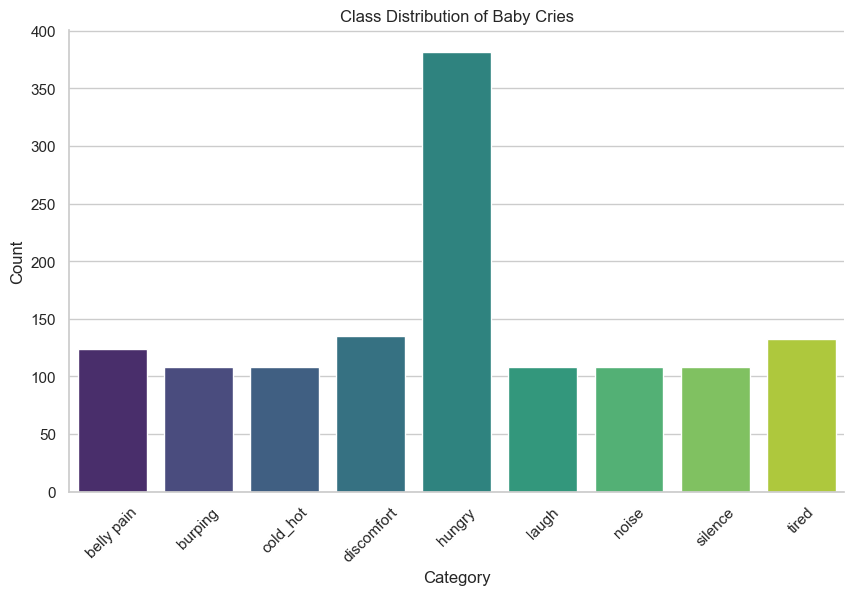

In [8]:
# Extract all labels
def extract_label_names(ds, labels):
    all_labels = [sample["label"] for sample in ds]
    label_names = [labels[i] for i in all_labels]
    return label_names

label_names = extract_label_names(ds, labels)

plt.figure(figsize=(10, 6))
sns.countplot(x=label_names, palette="viridis")
plt.title("Class Distribution of Baby Cries")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.gca().spines[['top', 'right']].set_visible(False)
# plt.show()

### Audio Duration Analysis

Average Duration: 6.33 seconds
Sampling Rates: {8000, 44100} Hz


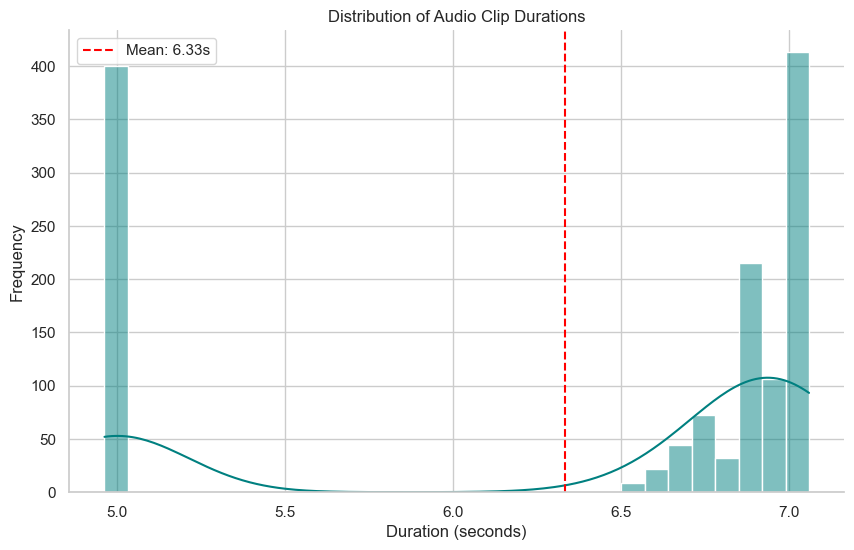

In [9]:
# Calculate duration for all samples (array length / sampling rate)

def extract_audio_duration_sampling_rates(ds):
    durations = []
    sampling_rates = []

    for sample in ds:
        audio = sample["audio"]
        # 'array' is the waveform data, 'sampling_rate' is Hz
        # audio data might be pre-decoded by datasets library
        durations.append(len(audio["array"]) / audio["sampling_rate"])
        sampling_rates.append(audio["sampling_rate"])
    return durations, sampling_rates

durations, sampling_rates = extract_audio_duration_sampling_rates(ds)
avg_duration = np.mean(durations)
print(f"Average Duration: {avg_duration:.2f} seconds")
print(f"Sampling Rates: {set(sampling_rates)} Hz")

plt.figure(figsize=(10, 6))
sns.histplot(durations, kde=True, bins=30, color="teal")
plt.title("Distribution of Audio Clip Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.axvline(avg_duration, color='red', linestyle='--', label=f'Mean: {avg_duration:.2f}s')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
# plt.show()

### Signal Visualization (Waveform & Spectrogram)

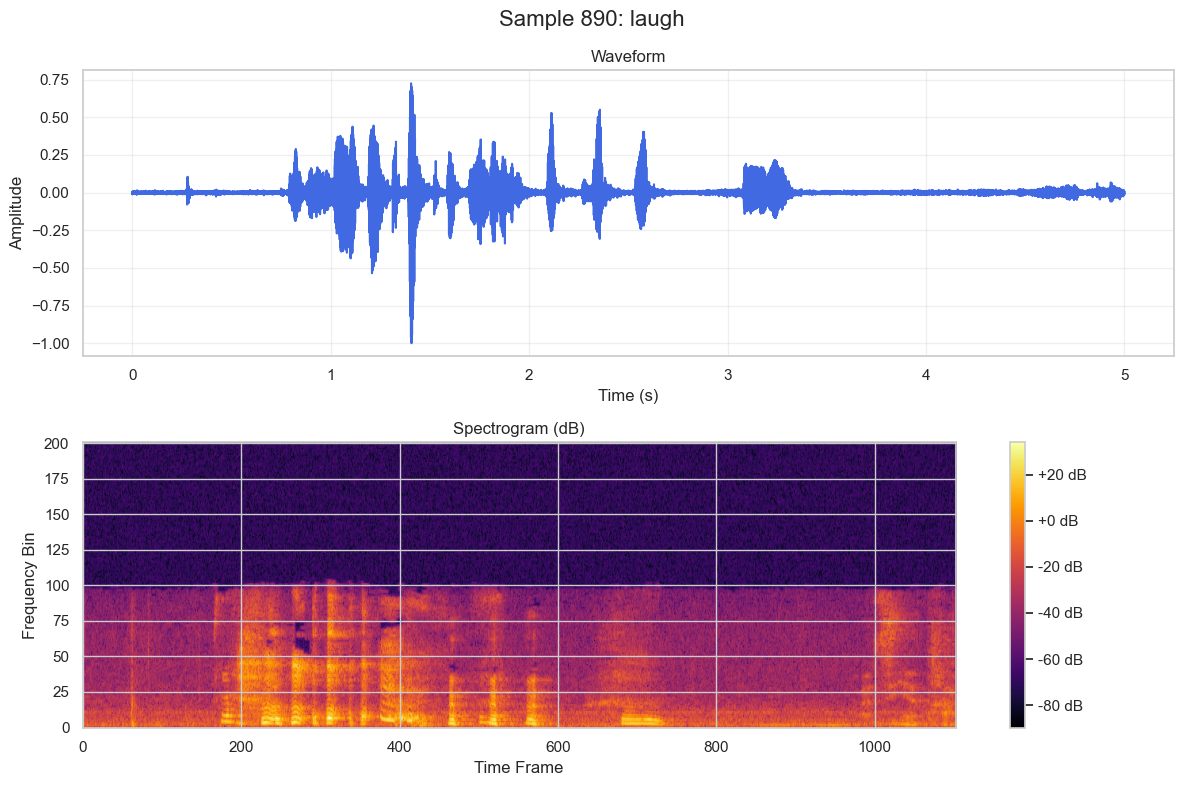

In [10]:
def plot_waveform_spectrogram(sample_idx):
    sample = ds[sample_idx]
    waveform = torch.tensor(sample["audio"]["array"]).float()
    sr = sample["audio"]["sampling_rate"]
    label = labels[sample["label"]]

    # Create spectrogram
    spectrogram_transform = torchaudio.transforms.Spectrogram()
    spectrogram = spectrogram_transform(waveform)

    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
    fig.suptitle(f"Sample {sample_idx}: {label}", fontsize=16)

    # Plot Waveform
    times = np.arange(len(waveform)) / sr
    axs[0].plot(times, waveform.numpy(), color='royalblue')
    axs[0].set_title("Waveform")
    axs[0].set_ylabel("Amplitude")
    axs[0].set_xlabel("Time (s)")
    axs[0].grid(True, alpha=0.3)

    # Plot Spectrogram
    # Convert to dB for better visualization
    spec_db = 10 * np.log10(spectrogram.numpy() + 1e-9)
    im = axs[1].imshow(spec_db, aspect='auto', origin='lower', cmap='inferno')
    axs[1].set_title("Spectrogram (dB)")
    axs[1].set_ylabel("Frequency Bin")
    axs[1].set_xlabel("Time Frame")
    plt.colorbar(im, ax=axs[1], format='%+2.0f dB')

    plt.tight_layout()
    # plt.show()

# Plot a random sample
random_idx = random.randint(0, len(ds) - 1)
plot_waveform_spectrogram(random_idx)

Visualizing class: belly pain
Visualizing class: burping
Visualizing class: cold_hot
Visualizing class: discomfort
Visualizing class: hungry
Visualizing class: laugh
Visualizing class: noise
Visualizing class: silence
Visualizing class: tired


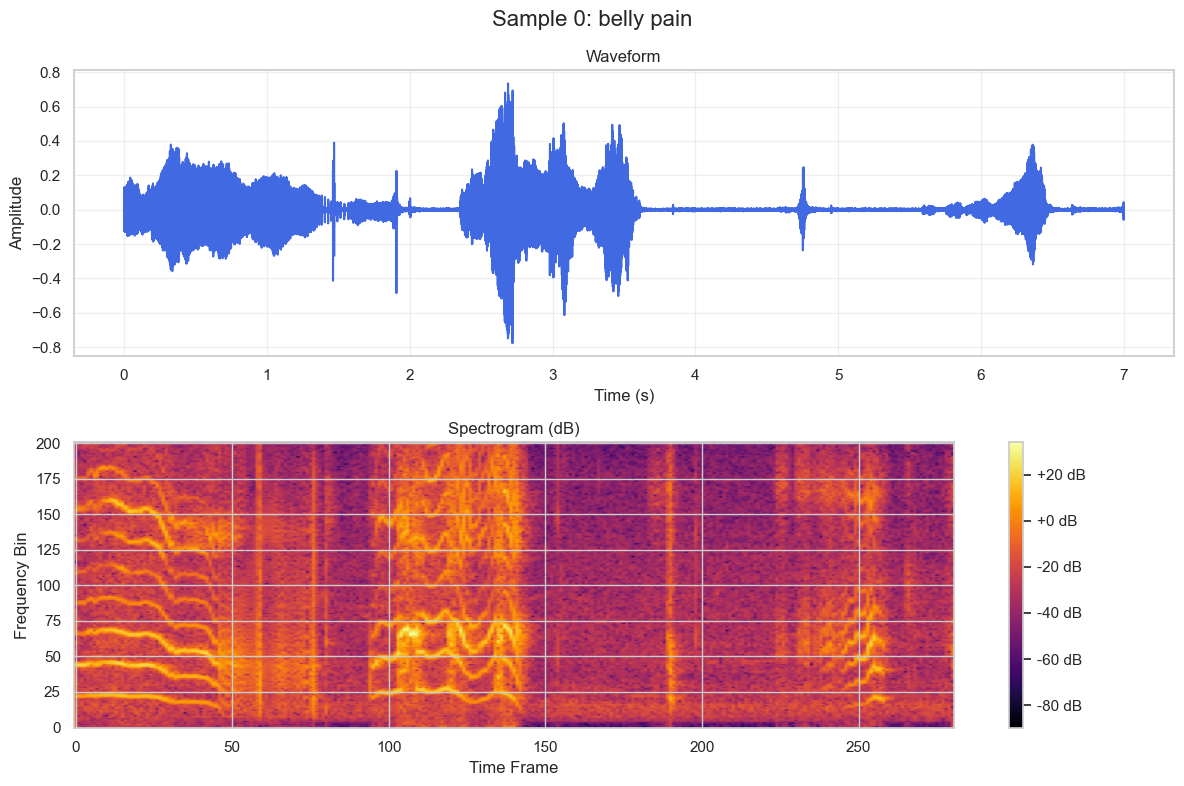

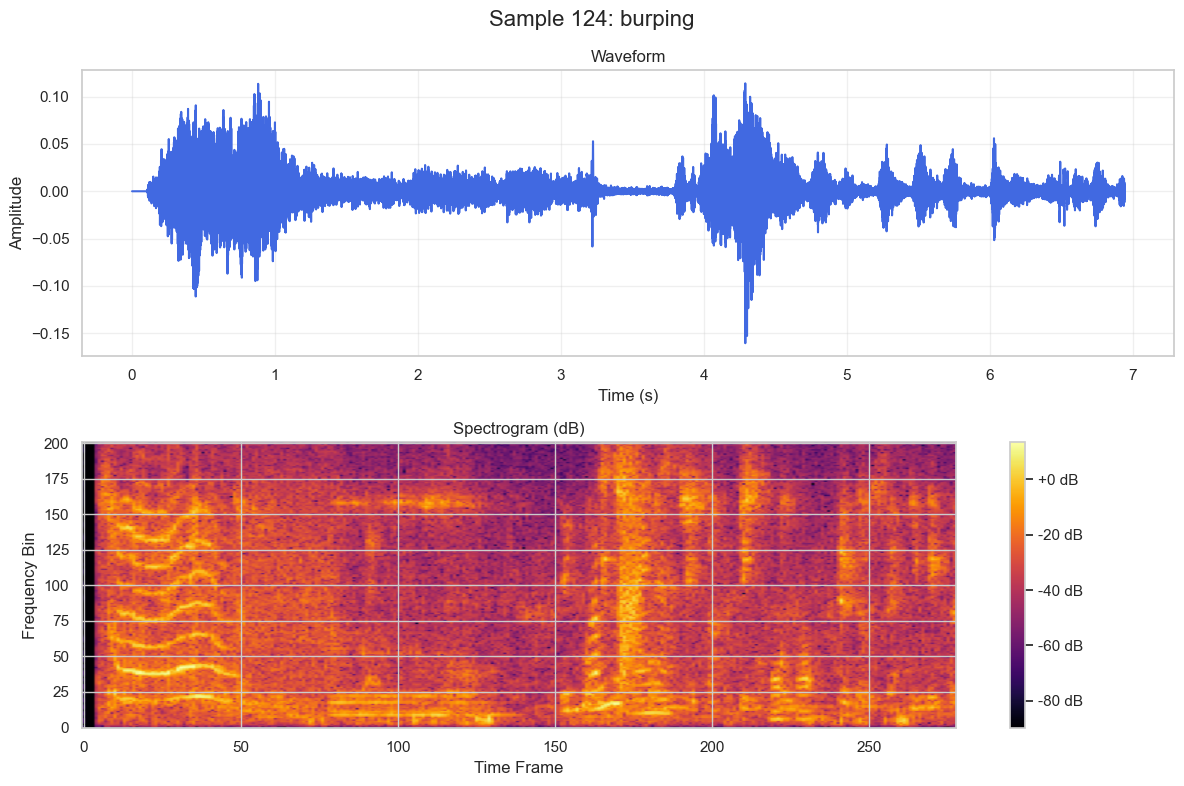

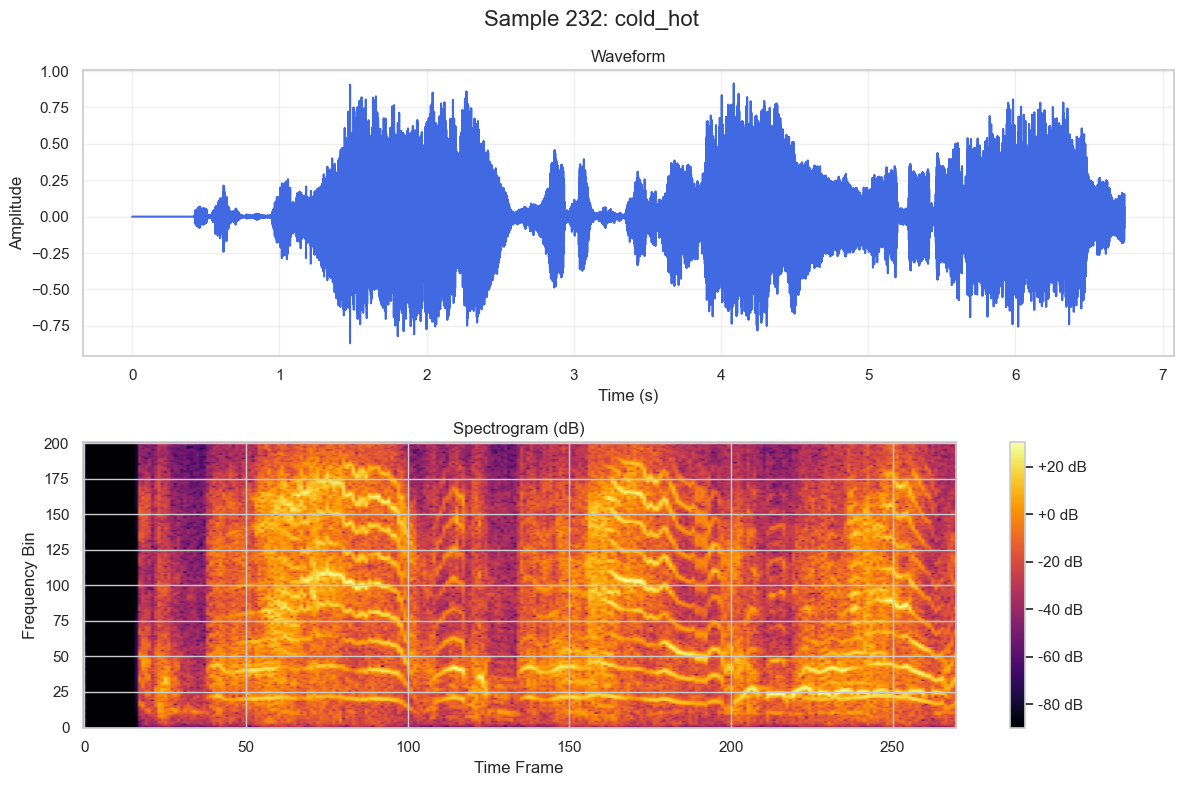

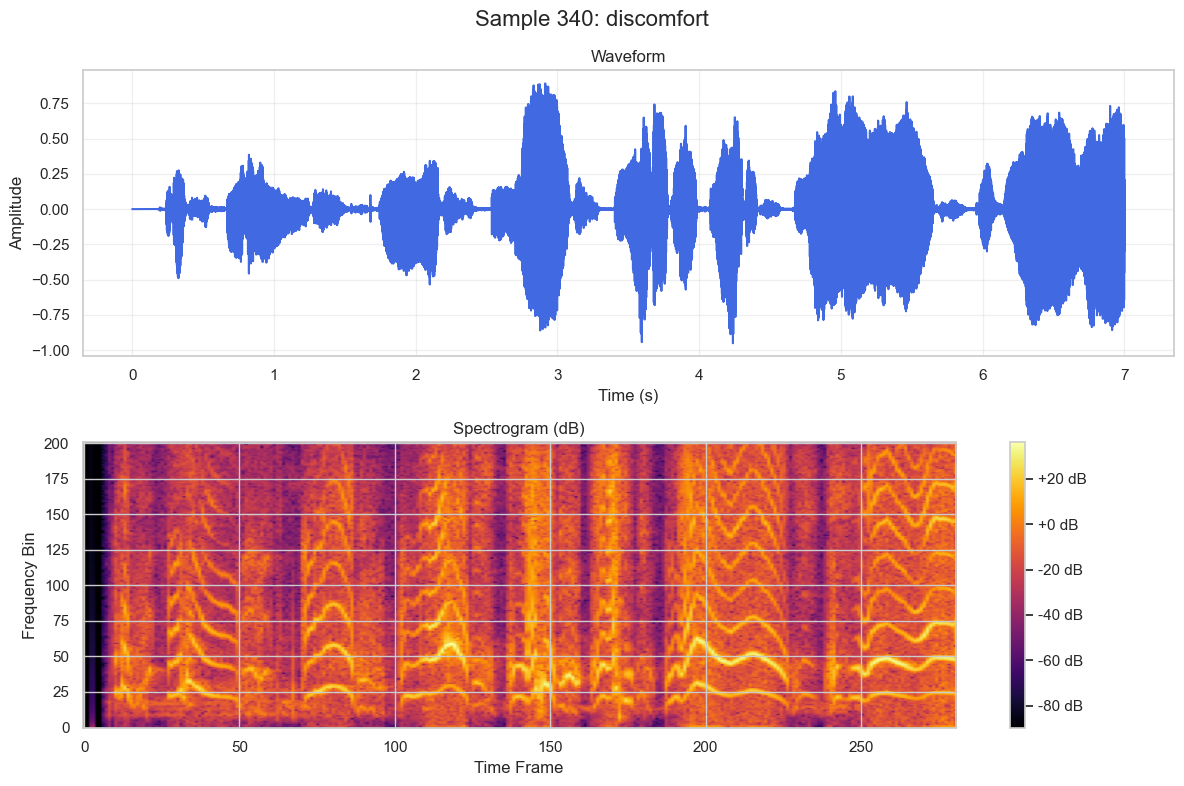

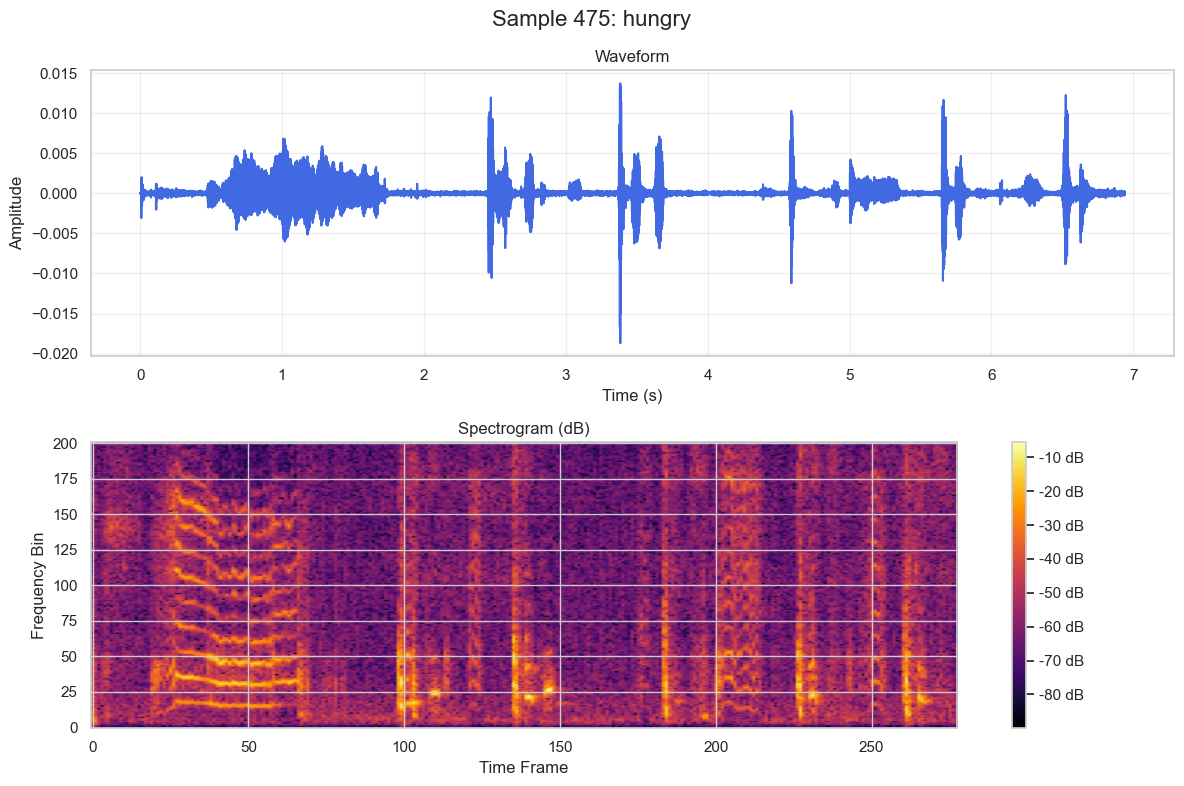

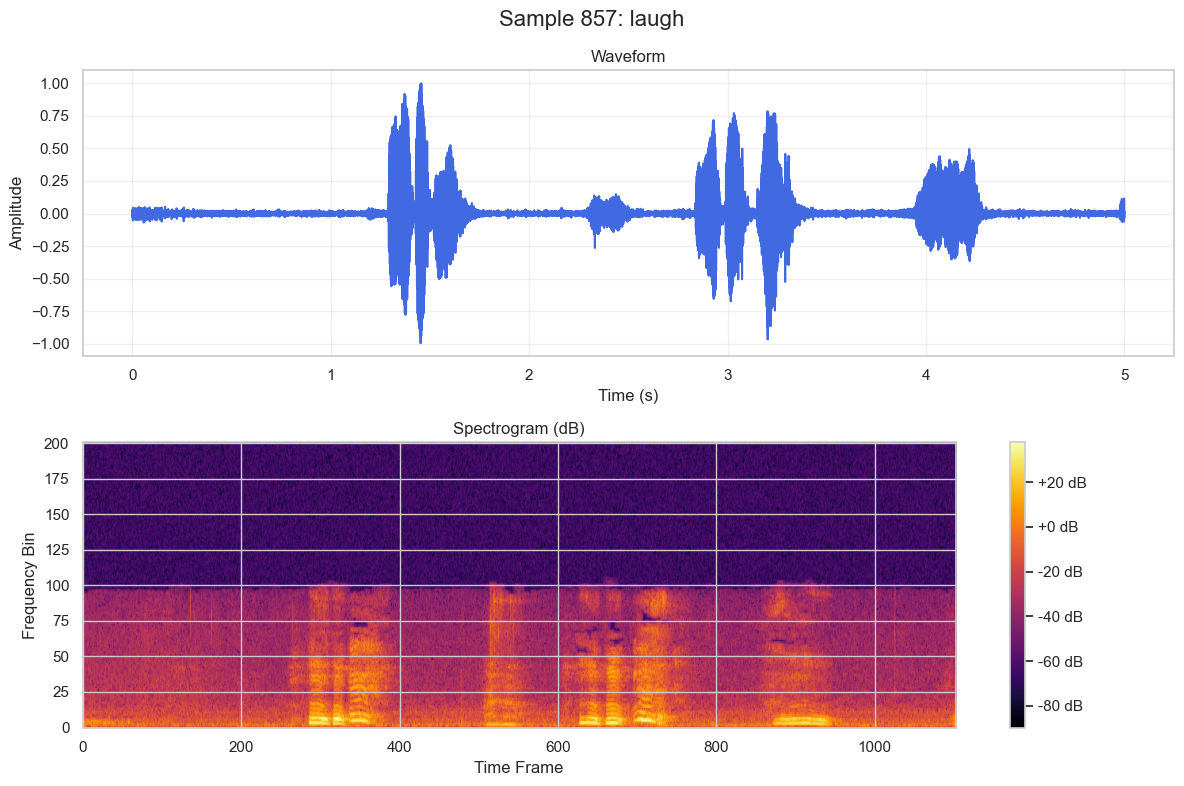

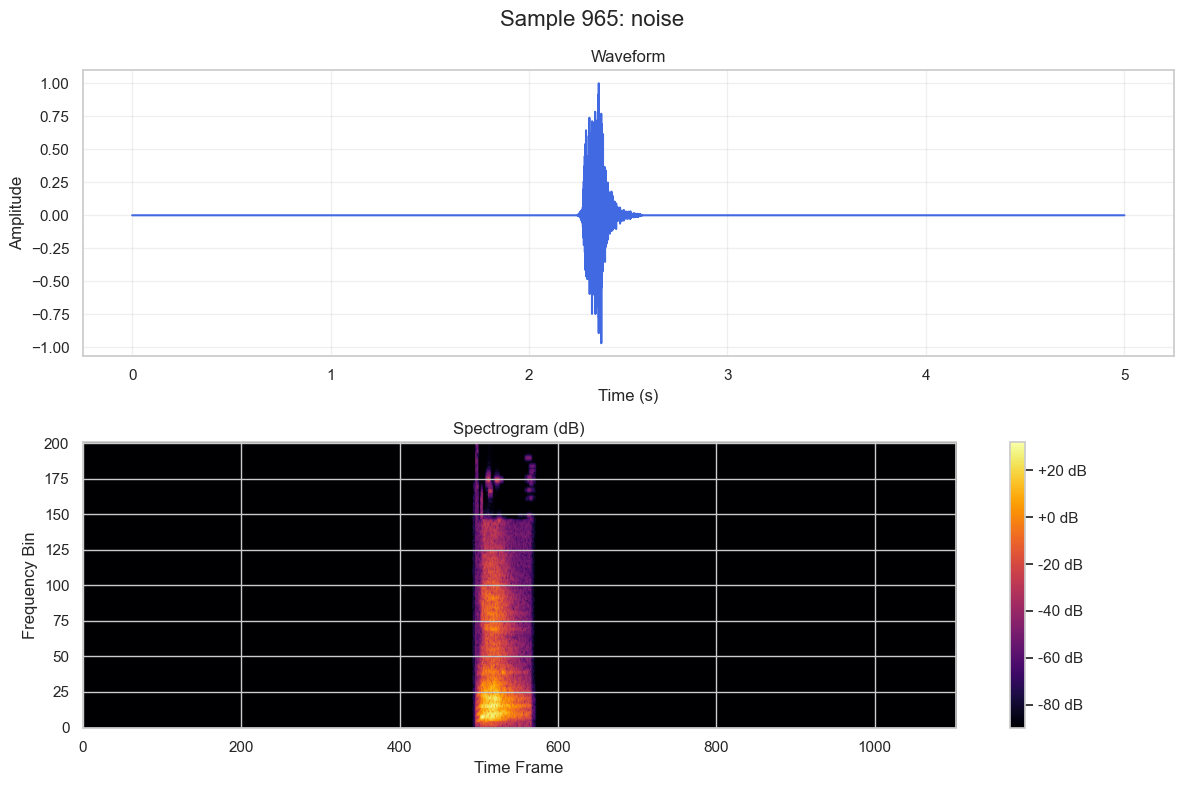

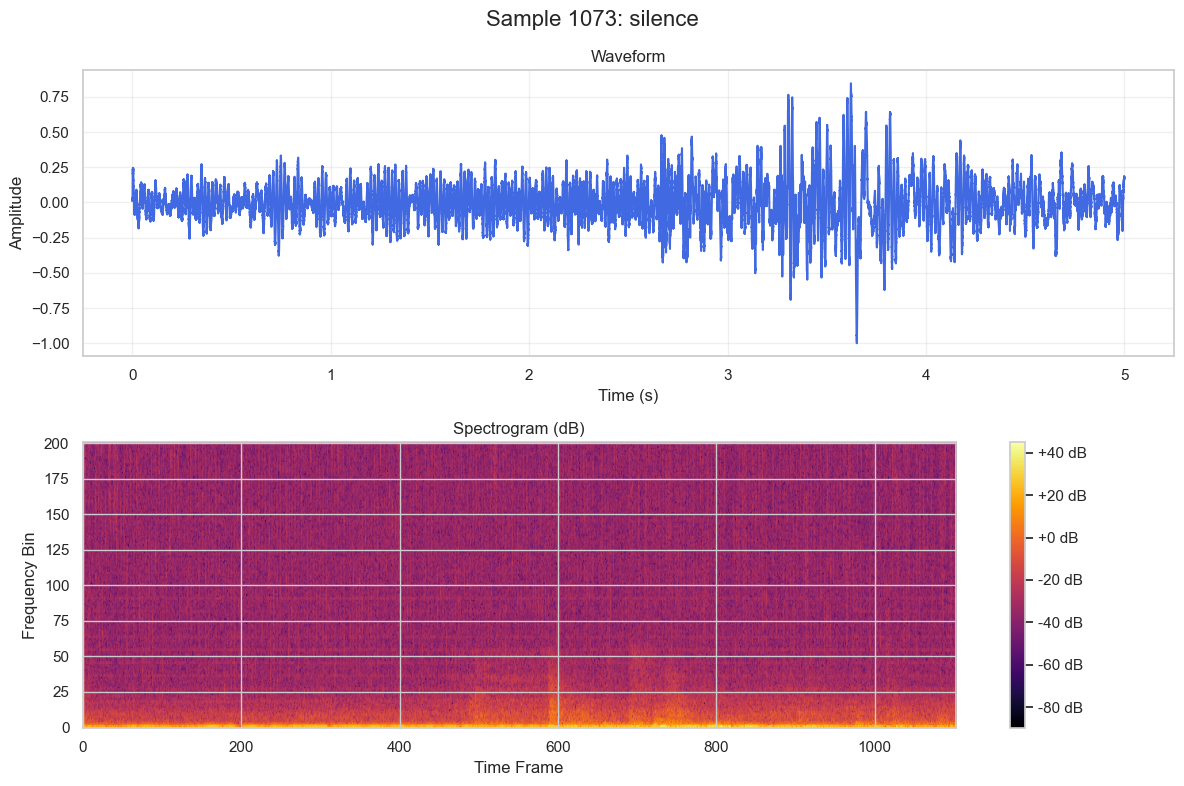

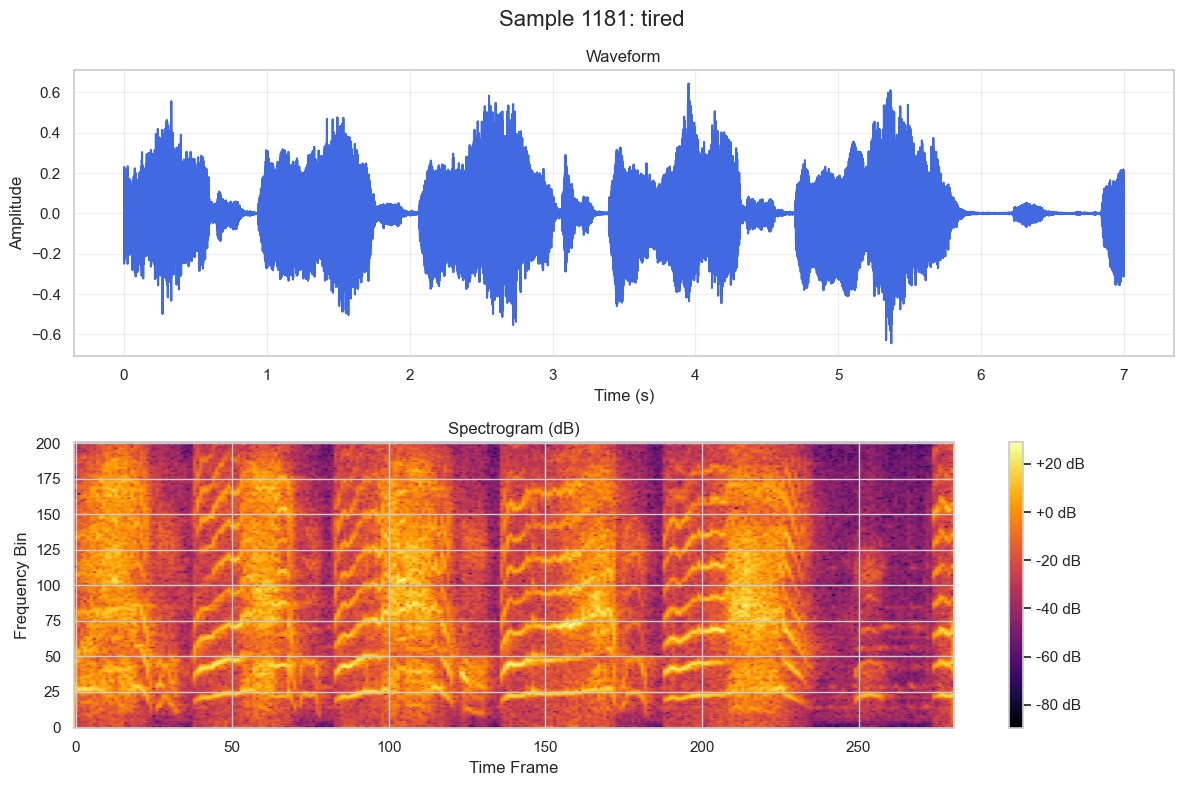

In [11]:
# Interactive selection (optional, if widgets available) or just loop
# Here we show one example per class

def run_interactive_session(ds, labels):
    unique_labels = set(sample_["label"] for sample_ in ds)

    for label_id in unique_labels:
        # Find first sample with this label
        for i, sample in enumerate(ds):
            if sample['label'] == label_id:
                print(f"Visualizing class: {labels[label_id]}")
                plot_waveform_spectrogram(i)
                break

run_interactive_session(ds, labels)